In [272]:
train = pd.read_csv("../dataset/train.csv")
original_train = train.copy()
test = pd.read_csv("../dataset/test.csv")
original_test = test.copy()

# Basic Features

In [273]:
# 반품 발생은 0으로 표기하는 컬럼 추가
train["Count"] = train["ScanCount"]
train.loc[train.Count < 0, "Count"] = 0
# Fineline 없는 것은 9999로 명시
train["FinelineNumber"].fillna(value=9999, inplace=True)
# Upc 없는 것은 -1로 명시
train["Upc"].fillna(value=-1, inplace=True)

In [274]:
wd = {
    "Monday": 0,
    "Tuesday": 1,
    "Wednesday": 2,
    "Thursday": 3, 
    "Friday": 4,
    "Saturday": 5,
    "Sunday": 6,
}

train["Weekday"] = train["Weekday"].apply(lambda x: wd[x])

In [275]:
# train["Upc"] = train["Upc"].apply(lambda x: float_to_str(x))
# train["check"] = train.Upc.apply(check_digit)
# train["full_upc"] = train.Upc.apply(full_upc)
# train["company"] = train.full_upc.apply(company)

In [276]:
# data['DepartmentDescription'] = preprocessing.LabelEncoder().fit_transform(list(data['DepartmentDescription'])) 

In [277]:
# VisitNumber, DepartmentDescription으로 groupby. ScanCount sum(총 판매량) 
df = train.groupby(["VisitNumber", "DepartmentDescription"], as_index=False)["Count"].sum()

df1 = df.groupby(["VisitNumber"], as_index=False)["Count"].min()
df1.rename(columns={"Count": "Min"}, inplace=True)

df2 = df.groupby(["VisitNumber"], as_index=False)["Count"].max()
df2.rename(columns={'Count': "Max"}, inplace=True)

df3 = df.groupby(["VisitNumber"], as_index=False)["Count"].mean()
df3.rename(columns={"Count": "Mean"}, inplace=True)

train = train.merge(df1, how='left', on=["VisitNumber"], copy=True)
train = train.merge(df2, how='left', on=["VisitNumber"], copy=True)
train = train.merge(df3, how='left', on=["VisitNumber"], copy=True)  

train["Range"] = train["Max"] - train["Min"]

In [278]:
# def category_counts(data):
#     """
#     Count total number of unique DepartmentDescription made on each trip.
#     """
#     counts = []
#     for array in np.asarray(data.loc[:, "1-HR PHOTO":"WIRELESS"]):
#         count = 0
#         for item in array:
#             if item > 0:
#                 count += 1
#         counts.append(count)
#     cat_counts = pd.DataFrame(counts)
#     cat_counts = cat_counts.rename(columns={0:"CategoryCount"})
#     cat_counts = cat_counts.set_index(data.index)
#     data.insert(4, "CategoryCounts", cat_counts)

In [279]:
df = train[train["DepartmentDescription"].isnull()]
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()
df.rename(columns={"Count": "Null_Depts"}, inplace=True)
train = train.merge(df, how='left', on=["VisitNumber"], copy=True) 
train["Null_Depts"].fillna(value=1, inplace=True)
train.loc[train.Null_Depts > 0, "Null_Depts"] = 0

In [280]:
df = train[train["ScanCount"] < 0]
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()
df.rename(columns={"Count": "ReturnCount"}, inplace=True) 
train = train.merge(df, how='left', on=["VisitNumber"], copy=True)
train["ReturnCount"].fillna(value=1, inplace=True)
train.loc[train.ReturnCount > 0, "ReturnCount"] = 0

In [281]:
# Indicator for missing FinelineNumber

df = train[train["FinelineNumber"]==9999]
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()
df.rename(columns={"Count": "Null_Fineline"}, inplace=True)
train = train.merge(df, how='left', on=["VisitNumber"], copy=True)
train["Null_Fineline"].fillna(value=1, inplace=True)
train.loc[train.Null_Fineline > 0, "Null_Fineline"] = 0

In [282]:
# 각 VisitNumber 당 총 구매한 FinelineNumber의 수

df = train.groupby(["VisitNumber",  "FinelineNumber"], as_index=False)["Count"].count()
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()
df.rename(columns={"Count": "N_Fineline"}, inplace=True) 
train = train.merge(df, how='left', on=["VisitNumber"], copy=True)

In [283]:
# 각 소비자 당 총 구매한 UPC의 수

df = train.groupby(["VisitNumber",  "Upc"], as_index=False)["Count"].count()
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()
df.rename(columns={"Count": "N_Upc"}, inplace=True) 
train = train.merge(df, how='left', on=["VisitNumber"], copy=True) 

In [284]:
# 각 소비자 당 총 구매한 DepartmentDescription의 수

df = train.groupby(["VisitNumber", "DepartmentDescription"], as_index=False)["Count"].count()
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()
df.rename(columns={"Count": "N_Depts"}, inplace=True) 
train = train.merge(df, how='left', on=["VisitNumber"], copy=True)

In [285]:
df = train.groupby(["VisitNumber"], as_index=False)["Count"].sum()
df.rename(columns={"Count": "Sum"}, inplace=True)
train = train.merge(df, how='left', on=["VisitNumber"], copy=True)

In [286]:
train["Ratio_F_D"] = train["N_Fineline"] / train["N_Depts"]
train["Ratio_U_D"] = train["N_Upc"] / train["N_Depts"]
train.shape

(647054, 21)

In [287]:
train["mean_to_min"] = train["Mean"] / train["Min"]
train.loc[train.mean_to_min==0, "mean_to_min"] = 1
train['max_to_mean'] = train["Max"] / train["Mean"]
train.loc[train.max_to_mean==0, "max_to_mean"] = 1

In [288]:
train.drop("Upc", axis=1, inplace=True)
train.shape

(647054, 22)

In [19]:
# department_list = train["DepartmentDescription"].unique().tolist()
# def ratio_depts_products(data, department_list):
    
#     new_data = data[["VisitNumber", "Sum"]].drop_duplicates()
#     for i, dept in enumerate(department_list):
#         df = data[data["DepartmentDescription"]==dept]
#         df = df.groupby(["VisitNumber"], as_index=False)["Count"].sum()
#         df.rename(columns={"Count": "D_{}".format(dept)}, inplace=True)
#         new_data = new_data.merge(df, how='left', on=["VisitNumber"], copy=True)
#         new_data["D_{}".format(dept)].fillna(value=0, inplace=True)
#         new_data["Ratio_{}".format(dept)] = new_data["D_{}".format(dept)] / new_data["Sum"]
#         new_data["Ratio_{}".format(dept)].fillna(value=0, inplace=True)
#         new_data.drop(["D_{}".format(dept)], axis=1, inplace=True)
#     new_data.drop("Sum", axis=1, inplace=True)
#     return new_data

In [20]:
# tmp = train[["VisitNumber", "Sum"]]
# tmp = tmp.groupby("VisitNumber", as_index=False).max()

# new = train[["VisitNumber", "DepartmentDescription"]]

# dd_dummies = pd.get_dummies(new["DepartmentDescription"])
# new = pd.concat([new, dd_dummies], axis=1)
# new = new.groupby("VisitNumber", as_index=False).sum()

In [289]:
# 최빈값 함수
from collections import Counter
def mode(x):
    counts = Counter(x)
    max_count = max(counts.values())
    ls = [x_i for x_i, count in counts.items() if count == max_count]
    return ls[0]

In [290]:
to_grouped = train[["VisitNumber", "FinelineNumber"]]
mf_fineline = to_grouped.groupby("VisitNumber", as_index=False).agg(mode)

### Basic Feature 요약

- 

In [291]:
depts_dummies = pd.get_dummies(train.DepartmentDescription)
depts_dummies.drop("HEALTH AND BEAUTY AIDS", axis=1, inplace=True)

In [292]:
depts_dummies = pd.concat([train[["VisitNumber"]], depts_dummies], axis=1)
depts_dummies_grouped = depts_dummies.groupby("VisitNumber", as_index=False).sum()
depts_dummies_grouped.shape

(95674, 68)

In [46]:
# fineline_dummies = pd.get_dummies(train.FinelineNumber)
# fineline_dummies = pd.concat([train[["VisitNumber"]], fineline_dummies], axis=1)

In [293]:
def smoothing_depts(data):
    tmp = data[["VisitNumber", "Sum"]]
    tmp = tmp.groupby("VisitNumber", as_index=False).max()
    depts_dummies = pd.get_dummies(data["DepartmentDescription"])
    new_df = pd.concat([tmp, depts_dummies], axis=1)
    new_df = new_df.groupby("VisitNumber", as_index=False).sum()
    new_df = new_df.loc[:, "1-HR PHOTO":"WIRELESS"].apply(lambda x: (x+1) / (tmp["Sum"]+68))
    return new_df.drop(["HEALTH AND BEAUTY AIDS"], axis=1)

In [294]:
depts_smoothed = smoothing_depts(train)

In [47]:
# def make_fineline_dummies(data):
#     """
#     OneHotEncoding FinelineNumber which appear 
#     more than 500 times each Trip Type.
#     """
#     fineline_ranks = data.FinelineNumber.value_counts()
#     fineline_ranks = fineline_ranks[fineline_ranks > 500]
# #     columns1 = list(fineline_ranks.index)
#     dummies = pd.get_dummies(data.FinelineNumber)
#     dummies = dummies[fineline_ranks.index]
    
#     data_visit = original_train[["VisitNumber"]]
#     dummy_data = pd.concat([dummies, data_visit], axis=1)
#     dummy_data = dummy_data.groupby("VisitNumber", as_index=False).aggregate(np.sum) # agg("sum")보다 더 나은 성능
#     return dummy_data

In [48]:
# fineline_dummies_grouped = make_fineline_dummies(train)

In [295]:
train = train.replace(np.inf, 0)
train = train.fillna(value=0)

In [296]:
train.drop(["DepartmentDescription", "FinelineNumber"], axis=1, inplace=True)

In [297]:
train_by_max = train.groupby("VisitNumber", as_index=False).agg(np.max) # ScanCount --> Sum

In [298]:
train_grouped = train_by_max.merge(depts_dummies_grouped, how='left', on=["VisitNumber"])
# train_grouped = train_grouped.merge(fineline_dummies_grouped, how='left', on=["VisitNumber"])
train_grouped.shape

(95674, 87)

In [299]:
depts_tmp = train_grouped.loc[:, "1-HR PHOTO":"WIRELESS"]
depts_tmp = depts_smoothed
depts_tmp.columns = depts_tmp.columns.map(lambda x: str("Prob_") + x)

In [300]:
def grouping_depts(data):
    data["OPTICAL"] = data["OPTICAL - LENSES"] + data["OPTICAL - FRAMES"]
    data["DELI"] = data["SERVICE DELI"] + data["PRE PACKED DELI"]

    data["WOMENS CLOTHES"] = data["PLUS AND MATERNITY"] + data["LADIES SOCKS"] +\
                             data["LADIES SOCKS"] + data["BRAS & SHAPEWEAR"]
    data["ELECTRONICS"] = data["ELECTRONICS"] + data["PLAYERS AND ELECTRONICS"]
    data["LADIESWEAR"] = data["LADIESWEAR"] + data["WOMENS CLOTHES"]

    data["PHARMACY"] = data["PHARMACY RX"] + data["PHARMACY OTC"]
    data["LAWN AND GARDEN"] = data["LAWN AND GARDEN"] + data["HORTICULTURE AND ACCESS"]
    data["LADIESWEAR"] = data["SHEER HOSIERY"] + data["LADIESWEAR"]

    data["CLOTHES"] = data["BOYS WEAR"] + data["MENSWEAR"] + data["SWIMWEAR/OUTERWEAR"] +\
                      data['GIRLS WEAR, 4-6X  AND 7-14'] + data["INFANT APPAREL"] +\
                      data["LADIESWEAR"] + data["MENS WEAR"] + data["SLEEPWEAR/FOUNDATIONS"]

    data["GROCERIES"] = data["BAKERY"] + data["COMM BREAD"] + data["DAIRY"] + data["DSD GROCERY"] +\
                        data["FROZEN FOODS"] + data["GROCERY DRY GOODS"] + data["MEAT - FRESH & FROZEN"] +\
                        data["PRODUCE"] + data["SEAFOOD"] + data["DELI"]

    data["CLOTHES"] = data["CLOTHES"] + data["SHOES"]
    data["HOME"] = data["BATH AND SHOWER"] + data["HOME DECOR"] + data["HOME MANAGEMENT"] +\
                   data["BEDDING"] + data["COOK AND DINE"] + data["FURNITURE"] +\
                   data["LARGE HOUSEHOLD GOODS"] + data["SEASONAL"]

    data["JEWELRY AND ACCESSORIES"] = data["JEWELRY AND SUNGLASSES"] + data["ACCESSORIES"]
    data["ELECTRONICS"] = data["ELECTRONICS"] + data["CAMERAS AND SUPPLIES"]

    data['HOUSEHOLD GOODS'] = data['HOUSEHOLD PAPER GOODS'] + data['HOUSEHOLD CHEMICALS/SUPP']
    data["ELECTRONICS"] = data["ELECTRONICS"] + data["WIRELESS"]
    data["BEAUTY AND PERSONAL CARE"] = data["BEAUTY"] + data["PERSONAL CARE"]

    to_drop = ["OPTICAL - FRAMES", "OPTICAL - LENSES", "CONCEPT STORES",
               "OTHER DEPARTMENTS", "PRE PACKED DELI", "SERVICE DELI", "PLUS AND MATERNITY", "LADIES SOCKS",
               "BRAS & SHAPEWEAR", "PLAYERS AND ELECTRONICS", "WOMENS CLOTHES", "PHARMACY RX", "PHARMACY OTC",
               "HORTICULTURE AND ACCESS", "SHEER HOSIERY", "BOYS WEAR", "MENSWEAR", "SWIMWEAR/OUTERWEAR",
               "GIRLS WEAR, 4-6X  AND 7-14", "INFANT APPAREL", "LADIESWEAR", "MENS WEAR", "SLEEPWEAR/FOUNDATIONS",
               "BAKERY", "COMM BREAD", "DAIRY", "DSD GROCERY", "FROZEN FOODS", "GROCERY DRY GOODS",
               "MEAT - FRESH & FROZEN","PRODUCE", "SEAFOOD", "DELI", "SHOES", "HOME DECOR", "BATH AND SHOWER",
               "HOME MANAGEMENT", "BEDDING","COOK AND DINE", "FURNITURE", "LARGE HOUSEHOLD GOODS",
               "SEASONAL", "JEWELRY AND SUNGLASSES", "ACCESSORIES", "CAMERAS AND SUPPLIES",
               "HOUSEHOLD CHEMICALS/SUPP", "HOUSEHOLD PAPER GOODS", "WIRELESS", "BEAUTY", "PERSONAL CARE"]
    
    return data.drop(to_drop, axis=1)

In [301]:
train_depts_group = grouping_depts(train_grouped)
train_depts_group = pd.concat([train_depts_group, depts_tmp], axis=1)
train_depts_group.tail(3)

,VisitNumber,TripType,Weekday,ScanCount,Count,Min,Max,Mean,Range,Null_Depts,...,Prob_SEAFOOD,Prob_SEASONAL,Prob_SERVICE DELI,Prob_SHEER HOSIERY,Prob_SHOES,Prob_SLEEPWEAR/FOUNDATIONS,Prob_SPORTING GOODS,Prob_SWIMWEAR/OUTERWEAR,Prob_TOYS,Prob_WIRELESS
95671,191345,39,6,2,2,1.0,5.0,2.125,4.0,0.0,...,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765
95672,191346,39,6,1,1,1.0,5.0,2.125,4.0,0.0,...,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765
95673,191347,8,6,1,1,1.0,1.0,1.000,0.0,0.0,...,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286


In [302]:
# train_depts_group.drop(9999, axis=1, inplace=True)
train_depts_group = pd.concat([train_depts_group, mf_fineline[["FinelineNumber"]]], axis=1)
# train_depts_group = pd.get_dummies(train_depts_group, columns=["Weekday"])
# train_depts_group.drop(X.iloc[:, 170:357], axis=1, inplace=True)

In [306]:
train_depts_group = pd.get_dummies(train_depts_group, columns=["Weekday"])
train_depts_group.shape

(95674, 121)

In [350]:
y = train_depts_group["TripType"]
X = train_depts_group.drop("TripType", axis=1)

In [352]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [353]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [354]:
n_estimators = 1000
max_features = 0.6
min_samples_split = 30

In [355]:
rf = RandomForestClassifier(n_estimators=n_estimators,
                            min_samples_split=min_samples_split, n_jobs=-1, random_state=0)

In [356]:
%%time
rf.fit(X_train, y_train)

CPU times: user 4min 9s, sys: 6.77 s, total: 4min 16s
Wall time: 1min 11s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=30,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [357]:
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

0.739474601073
0.648898365316


In [358]:
pred = rf.predict(X_test)
pd.get_dummies(pred).shape

(23919, 35)

In [111]:
X_depts = X.loc[:, "OPTICAL":"BEAUTY AND PERSONAL CARE"]
lst = X_depts.columns.tolist()
for i in range(len(lst)-1):
    for j in range(i+1, len(lst)):
        X_depts['{}_{}'.format(lst[i], lst[j])] = X_depts[lst[i]] * X_depts[lst[j]]

In [112]:
X_depts_interaction = pd.concat([X, X_depts], axis=1)

In [113]:
X_train_interact, X_test_interact, y_train_interact, y_test_interact =\
train_test_split(X, y, test_size=0.4, random_state=0)

In [114]:
n_estimators = 500
max_features = 0.55
min_samples_split = 60

rf = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, criterion="entropy",
                            min_samples_split=min_samples_split, n_jobs=-1, random_state=0)

In [115]:
%%time
rf.fit(X_train_interact, y_train_interact)

CPU times: user 9min 48s, sys: 1.7 s, total: 9min 49s
Wall time: 2min 33s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.55, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=60,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [116]:
print(rf.score(X_train_interact, y_train_interact))
print(rf.score(X_test_interact, y_test_interact))

0.688593129399
0.649176900967


In [118]:
pred_interact_rf = rf.predict(X_test_interact)
pd.get_dummies(pred_interact_rf).shape

(38270, 31)

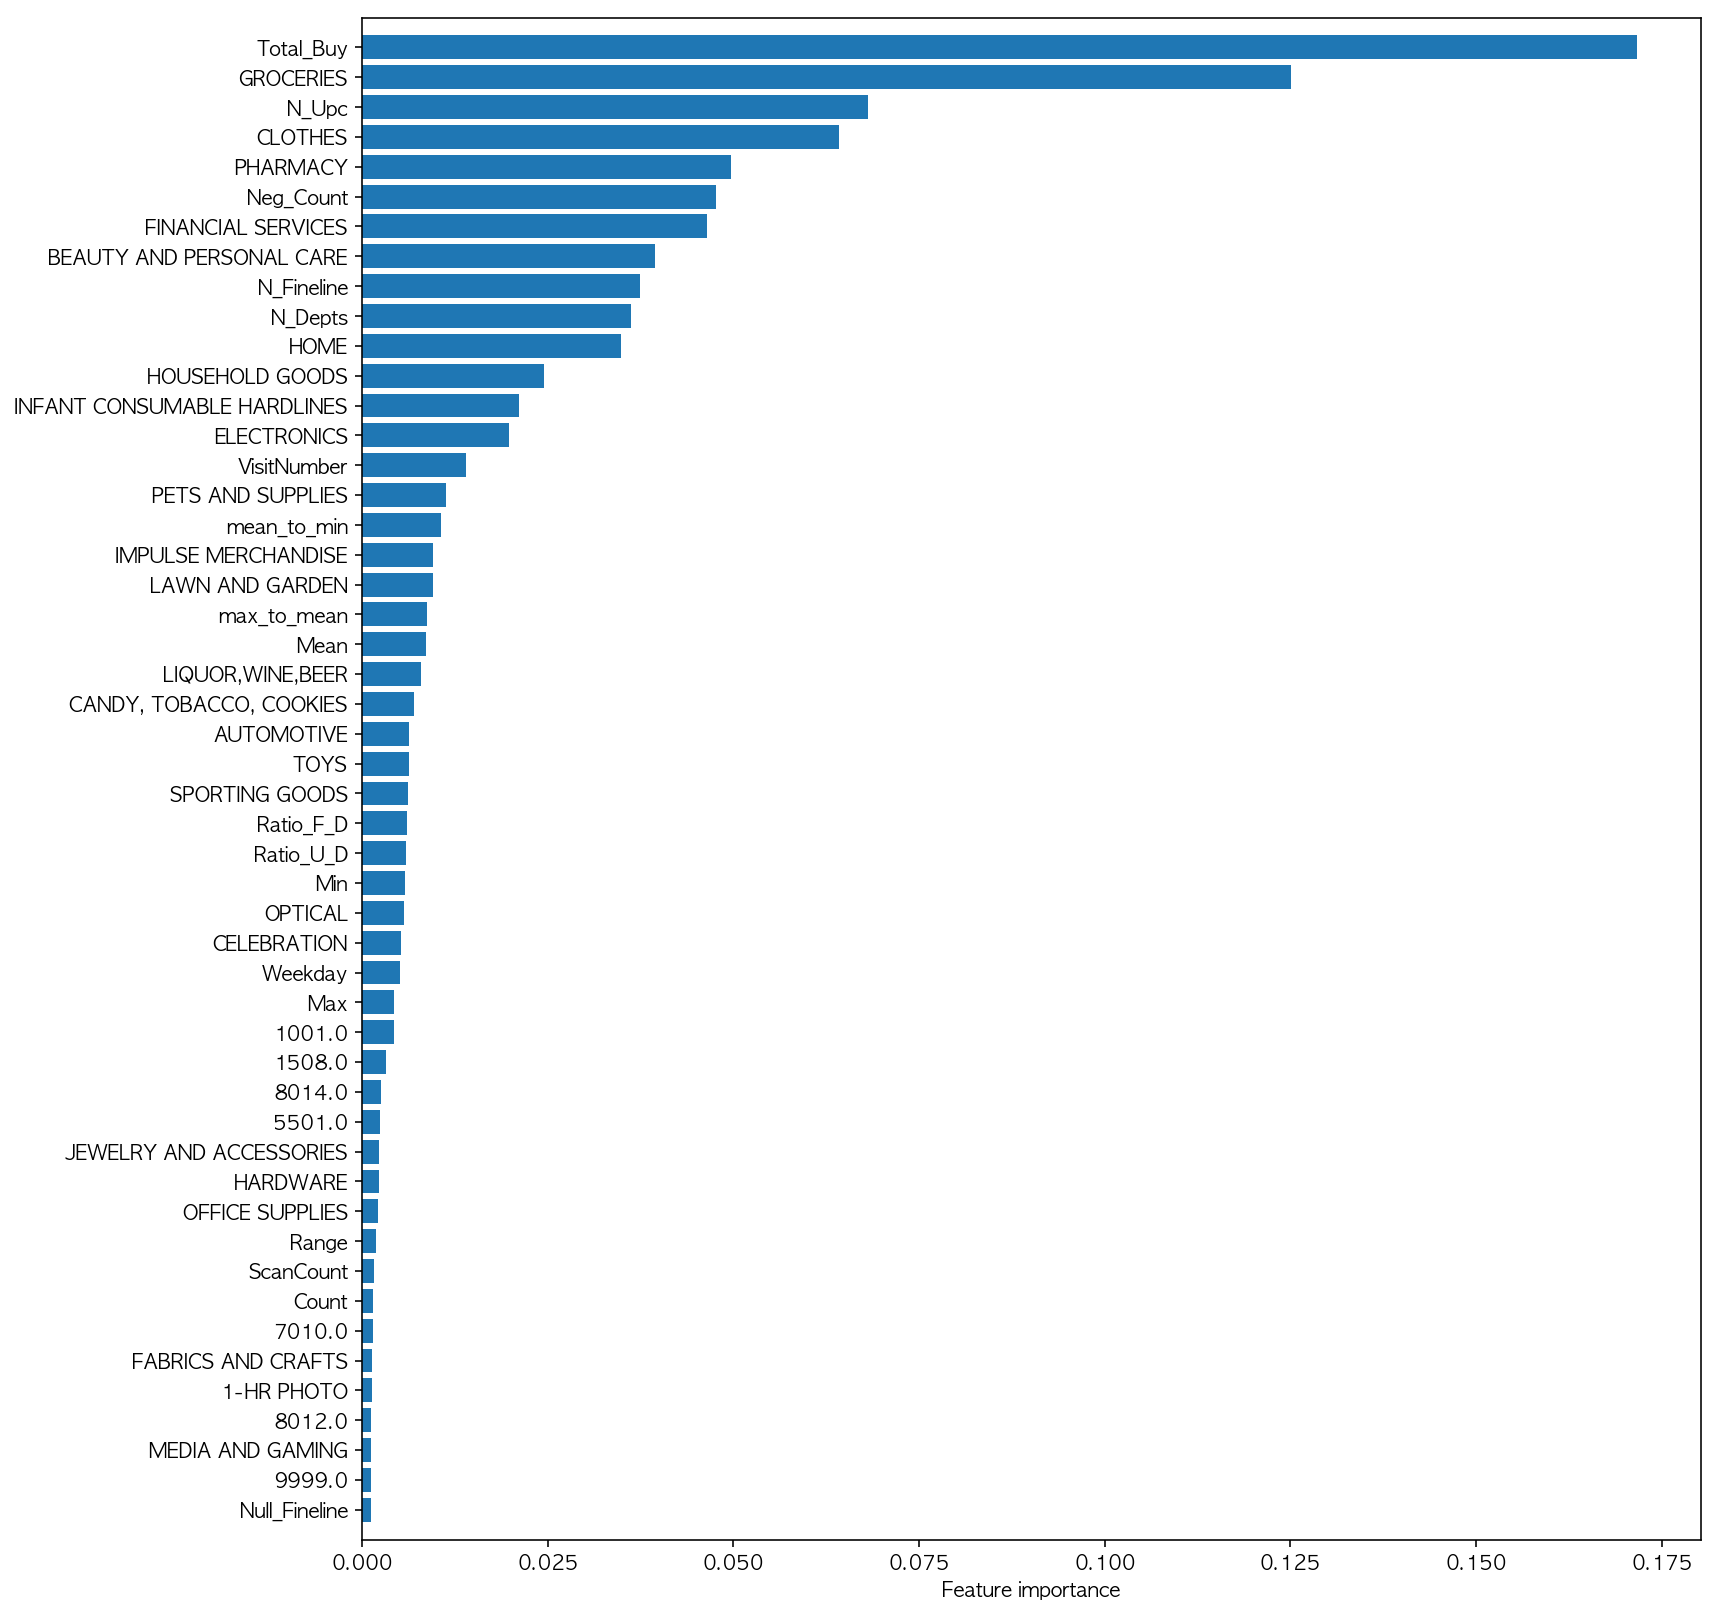

In [61]:
importance = rf.feature_importances_
pairs = []
for idx, value in enumerate(importance):
    pairs.append((abs(value), X.columns[idx]))
pairs.sort(key=lambda x: x[0], reverse=True)
# for pair in pairs[:20]:
#     print("importance: {:4f} feature: {}".format(pair[0], pair[1]))
importance.sort()
importance = importance[::-1]

labels = [label[1] for label in pairs]

plt.figure(figsize=(12, 14))
plt.barh(range(50), importance[:50][::-1], align="center")
plt.yticks(np.arange(50), labels[:50][::-1])
plt.xlabel("Feature importance")
plt.ylim(-1, 50)
plt.show()

In [211]:
def make_fineline_dummies_test(data):
    """
    OneHotEncoding FinelineNumber which appear 
    more than 500 times each Trip Type.
    """
#     train_fineline = original_data["FinelineNumber"].unique()
#     test_fineline = original_test["FinelineNumber"].unique()
#     intersection_fineline = list(set(train_fineline).intersection(set(test_fineline)))
    
    fineline_ranks = original_train.FinelineNumber.value_counts()
    fineline_ranks = fineline_ranks[fineline_ranks > 500]
#     columns1 = list(fineline_ranks.index)
    dummies = pd.get_dummies(data.FinelineNumber)
    dummies = dummies[fineline_ranks.index]
    
    data_visit = original_test[["VisitNumber"]]
    dummy_data = pd.concat([dummies, data_visit], axis=1)
    dummy_data = dummy_data.groupby("VisitNumber", as_index=False).aggregate(np.sum) # agg("sum")보다 더 나은 성능
    return dummy_data

In [320]:
wd = {
    "Monday": 0,
    "Tuesday": 1,
    "Wednesday": 2,
    "Thursday": 3, 
    "Friday": 4,
    "Saturday": 5,
    "Sunday": 6,
}

test["Weekday"] = test["Weekday"].apply(lambda x: wd[x])

test["Count"] = test["ScanCount"]
test.loc[test.Count < 0, "Count"] = 0
test["FinelineNumber"].fillna(value=9999, inplace=True)

In [321]:
df = test.groupby(["VisitNumber", "DepartmentDescription"], as_index=False)["Count"].sum()

df1 = df.groupby(["VisitNumber"], as_index=False)["Count"].min()
df1.rename(columns={"Count": "Min"}, inplace=True)

df2 = df.groupby(["VisitNumber"], as_index=False)["Count"].max()
df2.rename(columns={'Count': "Max"}, inplace=True)

df3 = df.groupby(["VisitNumber"], as_index=False)["Count"].mean()
df3.rename(columns={"Count": "Mean"}, inplace=True)

test = test.merge(df1, how='left', on=["VisitNumber"], copy=True)
test = test.merge(df2, how='left', on=["VisitNumber"], copy=True)
test = test.merge(df3, how='left', on=["VisitNumber"], copy=True)  

test["Range"] = test["Max"] - test["Min"]

In [323]:
df = test[test["DepartmentDescription"].isnull()]
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()
df.rename(columns={"Count": "Null_Depts"}, inplace=True)
test = test.merge(df, how='left', on=["VisitNumber"], copy=True) 
test["Null_Depts"].fillna(value=1, inplace=True) 
test.loc[test.Null_Depts > 0, "Null_Depts"] = 0

In [324]:
df = test[test["ScanCount"] < 0]
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()
df.rename(columns={"Count": "ReturnCount"}, inplace=True) 
test = test.merge(df, how='left', on=["VisitNumber"], copy=True)
test["ReturnCount"].fillna(value=1, inplace=True)
test.loc[test.ReturnCount > 0, "ReturnCount"] = 0

In [325]:
df = test[test["FinelineNumber"]==9999]
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()
df.rename(columns={"Count": "Null_Fineline"}, inplace=True)
test = test.merge(df, how='left', on=["VisitNumber"], copy=True) 

In [326]:
test["Null_Fineline"].fillna(value=0, inplace=True)
test.loc[test.Null_Fineline > 0, "Null_Fineline"] = 0

In [327]:
df = test.groupby(["VisitNumber",  "FinelineNumber"], as_index=False)["Count"].count()
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()
df.rename(columns={"Count": "N_Fineline"}, inplace=True) 
test = test.merge(df, how='left', on=["VisitNumber"], copy=True)

In [328]:
df = test.groupby(["VisitNumber",  "Upc"], as_index=False)["Count"].count()
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()
df.rename(columns={"Count": "N_Upc"}, inplace=True) 
test = test.merge(df, how='left', on=["VisitNumber"], copy=True) 

In [332]:
# 커널이 죽음... ???
df = test.groupby(["VisitNumber", "DepartmentDescription"], as_index=False)["Count"].count()

In [333]:
df = df.groupby(["VisitNumber"], as_index=False)["Count"].count()

In [334]:
df.rename(columns={"Count": "N_Depts"}, inplace=True) 
test = test.merge(df, how='left', on=["VisitNumber"], copy=True)

In [335]:
df = test.groupby(["VisitNumber"], as_index=False)["Count"].sum()
df.rename(columns={"Count": "Sum"}, inplace=True)
test = test.merge(df, how='left', on=["VisitNumber"], copy=True)

In [336]:
test["Ratio_F_D"] = test["N_Fineline"] / test["N_Depts"]
test["Ratio_U_D"] = test["N_Upc"] / test["N_Depts"]

test["mean_to_min"] = test["Mean"] / test["Min"]
test.loc[test.mean_to_min==0, "mean_to_min"] = 1
test['max_to_mean'] = test["Max"] / test["Mean"]
test.loc[test.max_to_mean==0, "max_to_mean"] = 1

test.drop("Upc", axis=1, inplace=True)

In [337]:
depts_dummies = pd.get_dummies(test.DepartmentDescription)

depts_dummies_test = pd.concat([test[["VisitNumber"]], depts_dummies], axis=1)
depts_dummies_test_grouped = depts_dummies_test.groupby("VisitNumber", as_index=False).sum()
depts_dummies_test_grouped.shape

(95674, 68)

In [25]:
# fineline_dummies_test = pd.get_dummies(test.FinelineNumber)
# fineline_dummies_test = pd.concat([test[["VisitNumber"]], fineline_dummies_test], axis=1)

In [338]:
def smoothing_depts_test(data):
    tmp = data[["VisitNumber", "Sum"]]
    tmp = tmp.groupby("VisitNumber", as_index=False).max()
    depts_dummies = pd.get_dummies(data["DepartmentDescription"])
    new_df = pd.concat([tmp, depts_dummies], axis=1)
    new_df = new_df.groupby("VisitNumber", as_index=False).sum()
    new_df = new_df.loc[:, "1-HR PHOTO":"WIRELESS"].apply(lambda x: (x+1) / (tmp["Sum"]+68))
    return new_df

In [339]:
depts_test_smoothed = smoothing_depts_test(test)
depts_tmp = test_grouped.loc[:, "1-HR PHOTO":"WIRELESS"]
depts_tmp = depts_test_smoothed
depts_tmp.columns = depts_tmp.columns.map(lambda x: str("Prob_") + x)

In [340]:
# fineline_dummies_test_grouped = make_fineline_dummies_test(test)

In [345]:
# to_grouped = test[["VisitNumber", "FinelineNumber"]]
to_grouped = test[["VisitNumber", "FinelineNumber"]]
mf_fineline_test = to_grouped.groupby("VisitNumber", as_index=False).agg(mode)

In [341]:
test = test.replace(np.inf, 0)
test = test.fillna(value=0)
test.drop(["DepartmentDescription", "FinelineNumber"], axis=1, inplace=True)

In [342]:
test_by_max = test.groupby("VisitNumber", as_index=False).agg(np.max)
test_grouped = test_by_max.merge(depts_dummies_test_grouped, how='left', on=["VisitNumber"])
# test_grouped = test_grouped.merge(fineline_dummies_test_grouped, how='left', on=["VisitNumber"])
test_grouped.shape

(95674, 86)

In [346]:
test_depts_group = grouping_depts(test_grouped)
test_depts_group = pd.concat([test_depts_group, depts_tmp], axis=1)
test_depts_group.shape

(95674, 113)

In [347]:
test_depts_group = pd.concat([test_depts_group, mf_fineline_test[["FinelineNumber"]]], axis=1)
test_depts_group = pd.get_dummies(test_depts_group, columns=["Weekday"])
test_depts_group.shape

(95674, 120)

In [361]:
test_depts_group.replace(np.inf, 0)
test_depts_group.fillna(value=0, inplace=True)

In [362]:
pred_test = rf.predict(test_depts_group)

In [363]:
pred_prob_test = rf.predict_proba(test_depts_group)

In [365]:
proba_df = pd.DataFrame(pred_prob_test, columns=rf.classes_)
proba_df.columns = proba_df.columns.map(lambda x: "TripType_" + str(x))
sub_df = pd.concat([test_depts_group[["VisitNumber"]], proba_df], axis=1)

In [367]:
sub_df.to_csv("../submission_0408.csv", index=False)

In [368]:
test_depts_group.to_csv("../dataset/0408_noFineline_test.csv", index=False)

In [369]:
import pickle
model = open("0408_rf_noFine.pickle", "wb")
pickle.dump(rf, model)

OSError: [Errno 22] Invalid argument

importance: 0.074409 feature: CLOTHES
importance: 0.073440 feature: Prob_WIRELESS
importance: 0.054302 feature: PHARMACY
importance: 0.044388 feature: OPTICAL
importance: 0.042222 feature: FABRICS AND CRAFTS
importance: 0.039457 feature: HOUSEHOLD GOODS
importance: 0.026036 feature: GROCERIES
importance: 0.022038 feature: JEWELRY AND ACCESSORIES
importance: 0.017312 feature: VisitNumber
importance: 0.016861 feature: Prob_OPTICAL - FRAMES
importance: 0.016344 feature: IMPULSE MERCHANDISE
importance: 0.015811 feature: Prob_LADIESWEAR
importance: 0.015179 feature: Ratio_U_D
importance: 0.014851 feature: Max
importance: 0.014782 feature: Prob_SEAFOOD
importance: 0.014728 feature: Prob_OPTICAL - LENSES
importance: 0.014532 feature: N_Depts
importance: 0.013267 feature: Prob_BRAS & SHAPEWEAR
importance: 0.012860 feature: CELEBRATION
importance: 0.012596 feature: HARDWARE


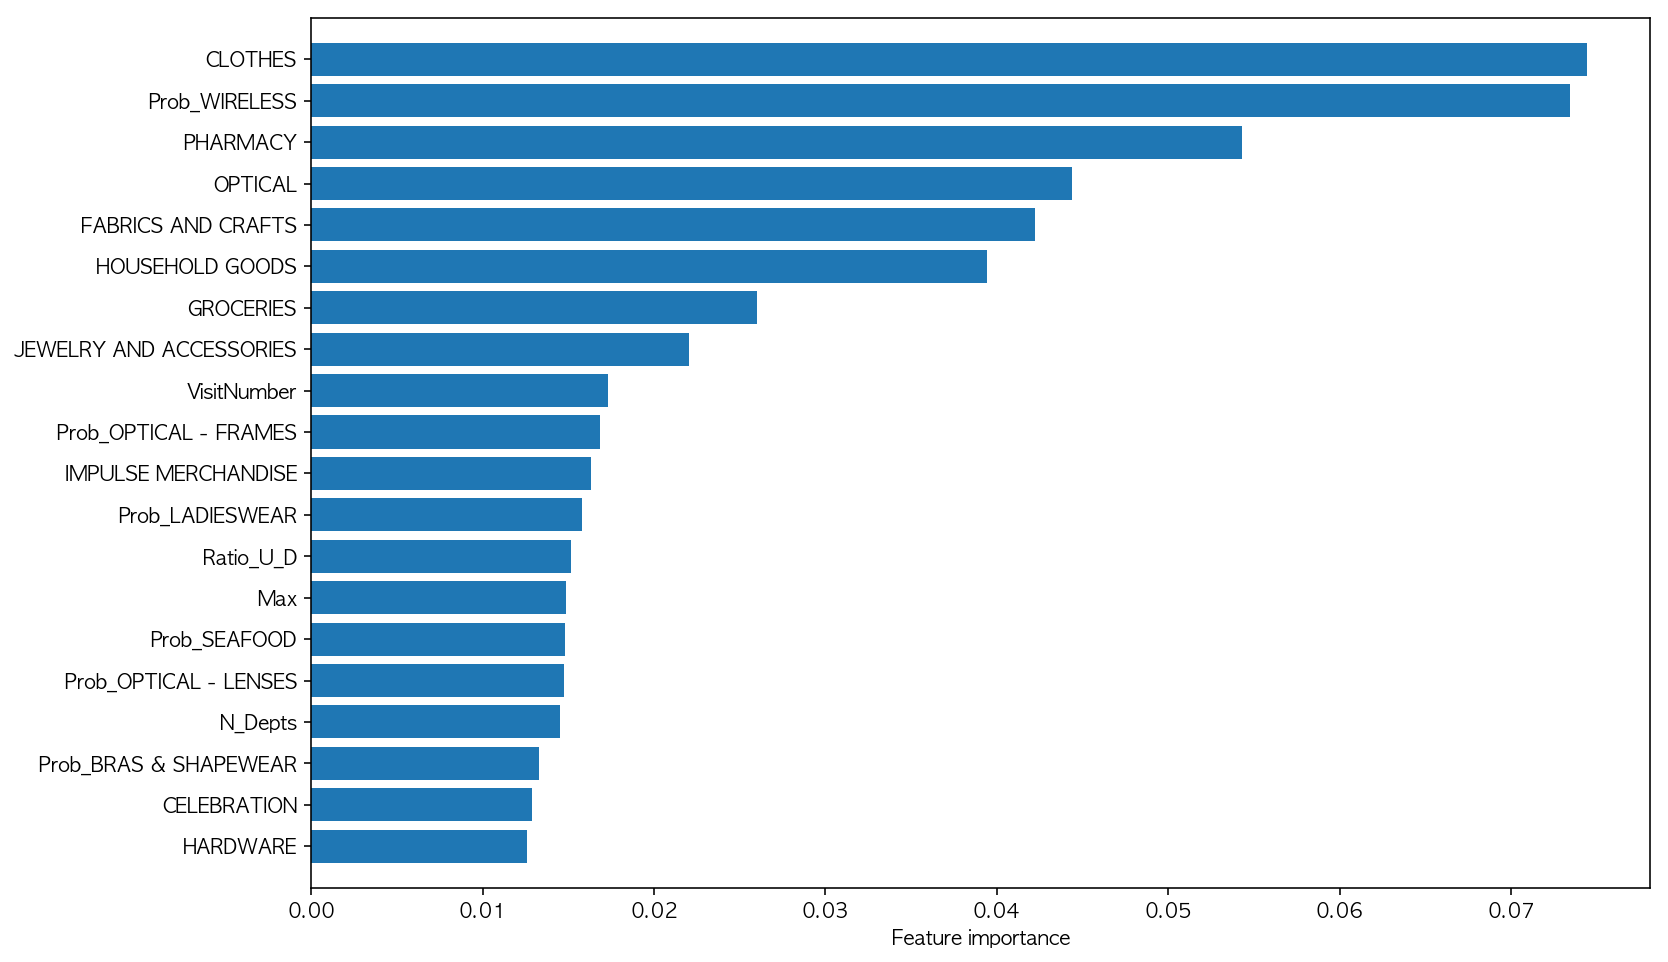

In [376]:
importance = rf.feature_importances_

pairs = []
for idx, value in enumerate(importance):
    pairs.append((abs(value), train_depts_group.columns[idx]))
pairs.sort(key=lambda x: x[0], reverse=True)
for pair in pairs[:20]:
    print("importance: {:4f} feature: {}".format(pair[0], pair[1]))

importance.sort()

importance = importance[::-1]

labels = [label[1] for label in pairs]

plt.figure(figsize=(12, 8))
plt.barh(range(20), importance[:20][::-1], align="center")
plt.yticks(np.arange(20), labels[:20][::-1])
plt.xlabel("Feature importance")
plt.ylim(-1, 20)
plt.show()

In [377]:
import xgboost as xgb
from sklearn.metrics import log_loss

In [397]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder().fit(y)

In [398]:
labeled_y = label.transform(y)

In [399]:
y_train_labeld, y_test_labeld = train_test_split(labeled_y, random_state=0)

In [404]:
dtrain = xgb.DMatrix(np.asarray(X_train), label = np.asarray(y_train_labeld))
dtest = xgb.DMatrix(np.asarray(X_test), label = np.asarray(y_test_labeld))

In [405]:
num_round = 10
param = {'objective': 'multi:softprob', 'num_class':38, 
         'eval_metric': 'mlogloss', "max_delta_step": 5, "eta": 0.01}
watchlist = [(dtrain,'train'), (dtest, 'eval')]

In [406]:
bst = xgb.train(param, dtrain, num_round, watchlist, 
                early_stopping_rounds=5)

[0]	train-mlogloss:3.59565	eval-mlogloss:3.59655
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 5 rounds.
[1]	train-mlogloss:3.5541	eval-mlogloss:3.55593
[2]	train-mlogloss:3.51294	eval-mlogloss:3.51564
[3]	train-mlogloss:3.47197	eval-mlogloss:3.47558
[4]	train-mlogloss:3.43149	eval-mlogloss:3.43606
[5]	train-mlogloss:3.39134	eval-mlogloss:3.39684
[6]	train-mlogloss:3.3516	eval-mlogloss:3.35804
[7]	train-mlogloss:3.31239	eval-mlogloss:3.31977
[8]	train-mlogloss:3.27363	eval-mlogloss:3.28202
[9]	train-mlogloss:3.23543	eval-mlogloss:3.24481


In [414]:
num_round = 100
param1 = {'objective': 'multi:softmax', 'num_class':38, "max_delta_step": 1, "eta": 1}
watchlist1 = [(dtrain,'train'), (dtest, 'eval')]

bst1 = xgb.train(param1, dtrain, num_round, watchlist1, early_stopping_rounds=5)

[0]	train-merror:0.60623	eval-merror:0.611606
Multiple eval metrics have been passed: 'eval-merror' will be used for early stopping.

Will train until eval-merror hasn't improved in 5 rounds.
[1]	train-merror:0.427245	eval-merror:0.44496
[2]	train-merror:0.338053	eval-merror:0.365525
[3]	train-merror:0.318319	eval-merror:0.350015
[4]	train-merror:0.300314	eval-merror:0.342364
[5]	train-merror:0.289945	eval-merror:0.337807
[6]	train-merror:0.279911	eval-merror:0.335466
[7]	train-merror:0.270406	eval-merror:0.332957
[8]	train-merror:0.260734	eval-merror:0.331786
[9]	train-merror:0.250115	eval-merror:0.32794
[10]	train-merror:0.243328	eval-merror:0.325557
[11]	train-merror:0.236889	eval-merror:0.324512
[12]	train-merror:0.230047	eval-merror:0.323843
[13]	train-merror:0.223775	eval-merror:0.322589
[14]	train-merror:0.217462	eval-merror:0.322965
[15]	train-merror:0.211734	eval-merror:0.323467
[16]	train-merror:0.20662	eval-merror:0.323341
[17]	train-merror:0.20124	eval-merror:0.32192
[18]	t

In [416]:
for_test = xgb.DMatrix(np.asarray(test_depts_group))

In [417]:
pred_xgb = bst1.predict(for_test)

In [418]:
pred_xgb.shape

(95674,)

In [423]:
pred_xgb_df = pd.get_dummies(pred_xgb)

In [432]:
def prediction_to_csv(prediction):
    df_VN = pd.DataFrame(columns=["VisitNumber"])
    df_VN["VisitNumber"] = test_depts_group["VisitNumber"]
    df_TT = pd.DataFrame(columns=["TripType"])
    df_TT["TripType"] = prediction
    df_TT = pd.get_dummies(df_TT.TripType).astype(int, cbopy=False)
    df_TT = df_TT.rename(columns = {0:"TripType_3", 1: "TripType_4", 2: "TripType_5", 3: "TripType_6", 
                4: "TripType_7", 5: "TripType_8", 6: "TripType_9", 7: "TripType_12", 8: "TripType_14", 
                9: "TripType_15", 10: "TripType_18", 11: "TripType_19", 12: "TripType_20", 13: "TripType_21",
                14: "TripType_22", 15: "TripType_23", 16: "TripType_24", 17: "TripType_25", 18: "TripType_26", 
                19: "TripType_27", 20: "TripType_28", 21: "TripType_29", 22: "TripType_30", 23: "TripType_31", 
                24: "TripType_32", 25: "TripType_33", 26: "TripType_34", 27: "TripType_35", 28: "TripType_36", 
                29: "TripType_37", 30: "TripType_38", 31: "TripType_39", 32: "TripType_40", 33: "TripType_41", 
                34: "TripType_42", 35: "TripType_43", 36: "TripType_44", 37: "TripType_999"})
    trial = pd.concat([df_VN, df_TT], axis=1).set_index('VisitNumber')
    #trial["TripType_14"] = 0
    return trial.to_csv("../dataset/trial_0.csv")

In [433]:
prediction_to_csv(pred_xgb)

In [452]:
pred_xgb_sub = pd.read_csv("../dataset/trial_0.csv")
pred_xgb_sub.insert(9, "TripType_14", np.zeros(pred_xgb_sub.shape[0]))

In [453]:
pred_xgb_sub.head()

,VisitNumber,TripType_3,TripType_4,TripType_5,TripType_6,TripType_7,TripType_8,TripType_9,TripType_12,TripType_14,...,TripType_36,TripType_37,TripType_38,TripType_39,TripType_40,TripType_41,TripType_42,TripType_43,TripType_44,TripType_999
0,1,0,0,0,0,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,1,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,4,0,0,0,0,0,0,1,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,6,0,0,0,0,0,0,1,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [454]:
pred_xgb_sub.to_csv("../submission_0408_xgb.csv", index=False)

In [456]:
pred_xgb_proba = bst1.predict_proba(for_test)

AttributeError: 'Booster' object has no attribute 'predict_proba'

In [462]:
xgb.cv(nfold=5, dtrain=dtrain, params=param1, num_boost_round=10)

,test-merror-mean,test-merror-std,train-merror-mean,train-merror-std
0,0.619009,0.007524,0.609515,0.006718
1,0.446171,0.004325,0.426932,0.002260
2,0.365758,0.001577,0.334322,0.002877
3,0.352310,0.001917,0.310909,0.001044
4,0.345676,0.002191,0.294537,0.001170
5,0.341175,0.002853,0.281789,0.000858
6,0.337133,0.003751,0.269971,0.000698
7,0.333844,0.003557,0.259285,0.001009
8,0.332925,0.004784,0.250467,0.000911
9,0.332715,0.004130,0.241892,0.000619


In [460]:
num_round = 100
param1 = {'objective': 'multi:softmax', 'num_class':38, "max_delta_step": 1, "eta": 1}
watchlist1 = [(dtrain,'train'), (dtest, 'eval')]

bst1 = xgb.train(param1, dtrain, num_round, watchlist1, early_stopping_rounds=5)

KeyboardInterrupt: 

In [466]:
import pickle
with open("rd_best_0408.pickle", "wb") as fb:
    pickle.dump(rf, fb)

OSError: [Errno 22] Invalid argument

In [468]:
n_estimators = 1000
max_features = 0.8
min_samples_split = 40

rf2 = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features,
                             min_samples_split=min_samples_split, n_jobs=-1, random_state=0)

In [469]:
%%time
rf2.fit(X_train, y_train)

CPU times: user 36min 7s, sys: 10.3 s, total: 36min 17s
Wall time: 10min 25s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=40,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [470]:
print(rf2.score(X_train, y_train))
print(rf2.score(X_test, y_test))

0.757884467981
0.671767214348


In [471]:
pred_prob_test2 = rf2.predict_proba(test_depts_group)
proba_df2 = pd.DataFrame(pred_prob_test2, columns=rf2.classes_)
proba_df2.columns = proba_df2.columns.map(lambda x: "TripType_" + str(x))
sub_df2 = pd.concat([test_depts_group[["VisitNumber"]], proba_df2], axis=1)
sub_df2.to_csv("../submission_0408_02.csv", index=False)